In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
# Read and Understand Data
# Clean Data
# Prepare data for modelling
# Modelling
# Business Recommendation

In [3]:
# read the dataset
retail_df = pd.read_csv("Online_Retail.csv", sep=",", encoding="ISO-8859-1", header=0)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


### Clean Data

In [4]:
# missing values
round(100*(retail_df.isnull().sum())/len(retail_df), 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [5]:
# drop all rows having missing values
retail_df = retail_df.dropna()
retail_df.shape

(406829, 8)

### Data Preparation for Modelling

In [6]:
#R - Recency
#F - Frequency
#M - Monetary
# Cust_id Recency Frequency Monetary

In [7]:
retail_df['amount'] = retail_df.Quantity * retail_df.UnitPrice

In [8]:
grouped_df = retail_df.groupby(['CustomerID'])['amount'].sum()
grouped_df =  grouped_df.reset_index()

In [9]:
grouped_df.head()

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [10]:
frequency = retail_df.groupby(['CustomerID'])['InvoiceNo'].count()

In [11]:
frequency = frequency.reset_index()

In [12]:
frequency.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [13]:
frequency.columns = ['CustomerID', 'frequency']

In [14]:
frequency.head()


,CustomerID,frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [15]:
grouped_df = pd.merge(grouped_df, frequency, on='CustomerID',how='inner')

In [16]:
grouped_df

,CustomerID,amount,frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17
...,...,...,...
4367,18280.0,180.60,10
4368,18281.0,80.82,7
4369,18282.0,176.60,13
4370,18283.0,2094.88,756


In [17]:
#Recency (09/12/2011)
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'], format ='%d-%m-%Y %H:%M')

In [18]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [19]:
retail_df['diff'] = max(retail_df['InvoiceDate'])- retail_df['InvoiceDate']

In [20]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [21]:
lastPurchase = retail_df.groupby('CustomerID')['diff'].min()

In [22]:
lastPurchase = lastPurchase.reset_index()

In [23]:
grouped_df = pd.merge(grouped_df, lastPurchase, on='CustomerID',how='inner')

In [24]:
grouped_df.columns

Index(['CustomerID', 'amount', 'frequency', 'diff'], dtype='object')

In [25]:
grouped_df.columns = ['CustomerID', 'amount', 'frequency', 'recency']

In [26]:
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [27]:
grouped_df['recency'] =  grouped_df['recency'].dt.days

In [28]:
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [29]:
#Outlier Treatment
#Rescaling variables
#

<AxesSubplot:>

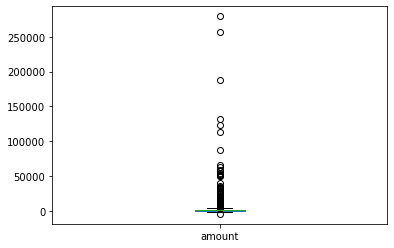

In [30]:
grouped_df.amount.plot.box()

In [31]:
# - Types of Outliers
# - Stastical Outliers
# - Domain Specific Outliers


In [32]:
#removing stattistical outliers

Q1 = grouped_df.amount.quantile(0.05)
Q3 = grouped_df.amount.quantile(0.95)

IQR = Q3-Q1
grouped_df = grouped_df[(grouped_df.amount>=Q1-1.5*IQR)& (grouped_df.amount<=Q3+1.5*IQR)]




In [33]:
Q1 = grouped_df.frequency.quantile(0.05)
Q3 = grouped_df.frequency.quantile(0.95)

IQR = Q3-Q1
grouped_df = grouped_df[(grouped_df.frequency>=Q1-1.5*IQR)& (grouped_df.frequency<=Q3+1.5*IQR)]

In [34]:
Q1 = grouped_df.recency.quantile(0.05)
Q3 = grouped_df.recency.quantile(0.95)

IQR = Q3-Q1
grouped_df = grouped_df[(grouped_df.recency>=Q1-1.5*IQR)& (grouped_df.recency<=Q3+1.5*IQR)]

<AxesSubplot:>

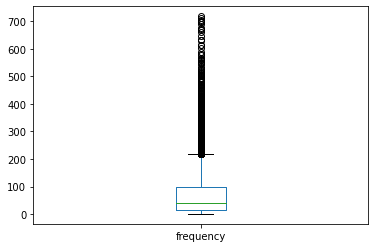

In [35]:
grouped_df.frequency.plot.box()

<AxesSubplot:>

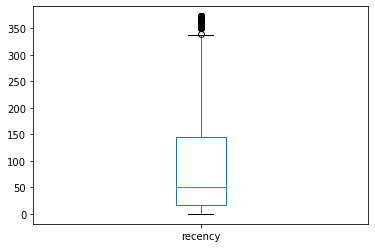

In [36]:
grouped_df.recency.plot.box()

In [37]:
#Rescaling
rfm_df = grouped_df[['amount', 'frequency', 'recency']]

In [38]:
scaler = StandardScaler()
rfm_df_scaled = scaler.fit_transform(rfm_df)

In [39]:
rfm_df_scaled.shape

(4293, 3)

In [40]:
#rfm_df_scaled.head()

In [41]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan

def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [42]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)

In [43]:
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']

In [44]:
hopkins(rfm_df_scaled)

0.960547360332576

### Modelling

In [45]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)


KMeans(max_iter=50, n_clusters=4)

In [46]:
kmeans.labels_

array([2, 0, 1, ..., 2, 1, 1])

In [47]:
len(kmeans.labels_)

4293

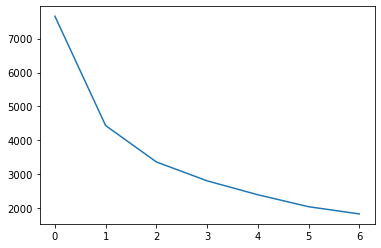

In [48]:
range_n_clusters = [2,3,4,5,6,7,8]
ssd = []
for range in range_n_clusters:
    kmeans = KMeans(n_clusters=range, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)

plt.plot(ssd)

In [49]:
range_n_clusters = [2,3,4,5,6,7,8]

for range in range_n_clusters:
    kmeans = KMeans(n_clusters=range, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    silhoute_avg =silhouette_score(rfm_df_scaled, cluster_labels)
    print('For n_clusters = {0}, silhoutescore is {1}'.format(range, silhoute_avg))


    

For n_clusters = 2, silhoutescore is 0.5415858652525395
For n_clusters = 3, silhoutescore is 0.5084896296141937
For n_clusters = 4, silhoutescore is 0.477782010021685
For n_clusters = 5, silhoutescore is 0.46613075550600325
For n_clusters = 6, silhoutescore is 0.417731425549664
For n_clusters = 7, silhoutescore is 0.4149957980854871
For n_clusters = 8, silhoutescore is 0.4077791676204188


In [50]:
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [51]:
kmeans.labels_

array([1, 2, 0, ..., 1, 0, 0])

In [52]:
grouped_df['cluster_id'] = kmeans.labels_
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,1


<AxesSubplot:xlabel='cluster_id', ylabel='amount'>

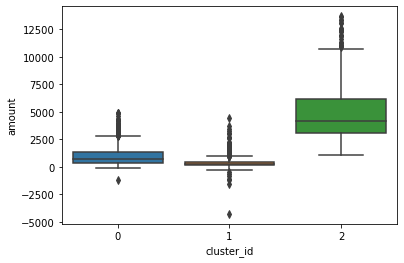

In [53]:
sns.boxplot(x='cluster_id', y = 'amount', data = grouped_df)

<AxesSubplot:xlabel='cluster_id', ylabel='recency'>

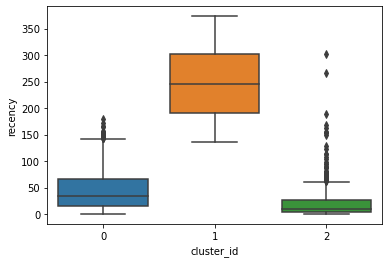

In [54]:
sns.boxplot(x='cluster_id', y = 'recency', data = grouped_df)

<AxesSubplot:xlabel='cluster_id', ylabel='frequency'>

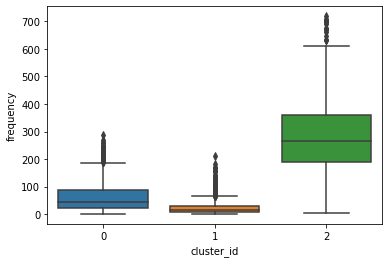

In [55]:
sns.boxplot(x='cluster_id', y = 'frequency', data = grouped_df)

In [57]:
cricket = pd.read_csv("Cricket.csv")

In [58]:
cricket.head()

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0
0,SR Tendulkar�(INDIA),1989-2012,463,452,41,18426,200*,44.83,21367,86.23,49,96,20
1,KC Sangakkara�(Asia/ICC/SL),2000-2015,404,380,41,14234,169,41.98,18048,78.86,25,93,15
2,RT Ponting�(AUS/ICC),1995-2012,375,365,39,13704,164,42.03,17046,80.39,30,82,20
3,ST Jayasuriya�(Asia/SL),1989-2011,445,433,18,13430,189,32.36,14725,91.20,28,68,34
4,DPMD Jayawardene�(Asia/SL),1998-2015,448,418,39,12650,144,33.37,16020,78.96,19,77,28


In [59]:
cluster_df = cricket[['SR', 'Ave']]

In [60]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(cluster_df)

In [61]:
kmeans = KMeans(n_clusters=4, random_state=100)
kmeans.fit(scaled_df)

KMeans(n_clusters=4, random_state=100)

In [62]:
kmeans.labels_

array([3, 1, 1, 0, 2, 1, 1, 1, 1, 1, 0, 1, 0, 3, 2, 3, 2, 0, 1, 1, 0, 1,
       2, 1, 0, 3, 2, 0, 2, 1, 2, 2, 1, 2, 3, 2, 2, 1, 3, 1, 2, 2, 3, 2,
       2, 2, 1, 2, 2, 1, 0, 1, 2, 2, 2, 2, 1, 0, 2, 0, 2, 0, 1, 3, 3, 1,
       1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 0, 2])

In [63]:
cricket['cluster'] = kmeans.labels_

In [65]:
pd.set_option('display.max_rows',100)

In [66]:
cricket.sort_values('cluster')

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,cluster
50,BB McCullum�(NZ),2002-2016,260,228,28,6083,166,30.41,6312,96.37,5,32,20,0
20,Yuvraj Singh�(Asia/INDIA),2000-2017,304,278,40,8701,150,36.55,9924,87.67,14,52,18,0
27,Shahid Afridi�(Asia/ICC/PAK),1996-2015,398,369,27,8064,124,23.57,6892,117.00,6,39,30,0
17,CH Gayle�(ICC/WI),1999-2015,269,264,17,9221,215,37.33,10834,85.11,22,47,23,0
12,AC Gilchrist�(AUS/ICC),1996-2008,287,279,11,9619,172,35.89,9922,96.94,16,55,19,0
10,TM Dilshan�(SL),1999-2016,330,303,41,10290,161*,39.27,11933,86.23,22,47,11,0
61,SK Raina�(INDIA),2005-2015,223,192,35,5568,116*,35.46,5938,93.76,5,36,14,0
24,V Sehwag�(Asia/ICC/INDIA),1999-2013,251,245,9,8273,219,35.05,7929,104.33,15,38,14,0
77,A Symonds�(AUS),1998-2009,198,161,33,5088,156,39.75,5504,92.44,6,30,15,0
57,EJG Morgan�(ENG/IRE),2006-2017,185,174,25,5772,124*,38.73,6513,88.62,11,34,12,0
